In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load the dataset
df = pd.read_csv('../data/raw/housing.csv')

print(f"Dataset loaded successfully.")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset loaded successfully.
Shape: (20640, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [3]:
# Handle missing values in total_bedrooms
print("Handling missing values...")

# Check missing values
missing_values = df.isnull().sum()
print(f"Missing values before: {missing_values.sum()}")

# Fill missing values with median
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

# Verify
missing_values_after = df.isnull().sum()
print(f"Missing values after: {missing_values_after.sum()}")
print("Missing values handled.")

Handling missing values...
Missing values before: 207
Missing values after: 0
Missing values handled.


In [4]:
# Feature Engineering
print("Feature Engineering...")

# Create new features
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# Create income categories
df['income_cat'] = pd.cut(df['median_income'],
bins=[0, 1.5, 3.0, 4.5, 6.0, 15.0],
labels=['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High'])

print("New features created:")
print("- rooms_per_household")
print("- bedrooms_per_room")
print("- population_per_household")
print("- income_cat")

Feature Engineering...
New features created:
- rooms_per_household
- bedrooms_per_room
- population_per_household
- income_cat


In [5]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Seperate features and target
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Handle categorical variables
categorical_cols = ['ocean_proximity', 'income_cat']
label_encoders = {}

for col in categorical_cols:
    le=LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Categorical columns encoded: {categorical_cols}")

Preparing data for modeling...
Feature shape: (20640, 13)
Target shape: (20640,)
Categorical columns encoded: ['ocean_proximity', 'income_cat']


In [6]:
# Train-test split
print("Creating train_test split...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Creating train_test split...
Training set: 16512 samples
Testing set: 4128 samples
Features: 13


In [9]:
# Model Training
print("Training multiple models...")

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale')
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 =r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

    print(f"Train R^2: {train_r2:.4f}")
    print(f"Test R^2: {test_r2:.4f}")
    print(f"Test RMSE: ${test_rmse:,.0f}")
    print(f"Test MAE: ${test_mae:,.0f}")

print("\nAll models trained.")


Training multiple models...

Training Linear Regression...
Train R^2: 0.6540
Test R^2: 0.5876
Test RMSE: $73,517
Test MAE: $51,570

Training Ridge Regression...
Train R^2: 0.6540
Test R^2: 0.5906
Test RMSE: $73,246
Test MAE: $51,520

Training Lasso Regression...
Train R^2: 0.6540
Test R^2: 0.5877
Test RMSE: $73,500
Test MAE: $51,567

Training Random Forest...
Train R^2: 0.9737
Test R^2: 0.8050
Test RMSE: $50,544
Test MAE: $32,718

Training Gradient Boosting...
Train R^2: 0.8056
Test R^2: 0.7781
Test RMSE: $53,928
Test MAE: $36,963

Training SVR...
Train R^2: -0.0544
Test R^2: -0.0487
Test RMSE: $117,229
Test MAE: $87,344

All models trained.


In [11]:
# Model Comparison
print("Model Comparison Results:")
print("=" * 80)

# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Train R^2': metrics['train_r2'],
        'Test R^2': metrics['test_r2'],
        'Test RMSE': metrics['test_rmse'],
        'Test MAE': metrics['test_mae']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R^2', ascending=False)

print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Test R^2: {comparison_df.iloc[0]['Test R^2']:.4f}")
print(f"Test RMSE: ${comparison_df.iloc[0]['Test RMSE']:,.0f}")

Model Comparison Results:
            Model  Train R^2  Test R^2     Test RMSE     Test MAE
    Random Forest   0.973726  0.805047  50543.799964 32718.094029
Gradient Boosting   0.805647  0.778066  53928.171261 36962.602446
 Ridge Regression   0.653993  0.590582  73246.460508 51519.618046
 Lasso Regression   0.654010  0.587744  73499.973730 51567.079116
Linear Regression   0.654011  0.587557  73516.556949 51570.254875
              SVR  -0.054393 -0.048733 117229.208647 87344.177280

Best Model: Random Forest
Test R^2: 0.8050
Test RMSE: $50,544


Feature Importance Analysis
Top 10 Features by Importance:
                     feature  importance
7              median_income    0.516455
11  population_per_household    0.133408
8            ocean_proximity    0.071119
1                   latitude    0.064225
0                  longitude    0.063906
2         housing_median_age    0.048962
9        rooms_per_household    0.026180
10         bedrooms_per_room    0.025272
4             total_bedrooms    0.012961
3                total_rooms    0.012896


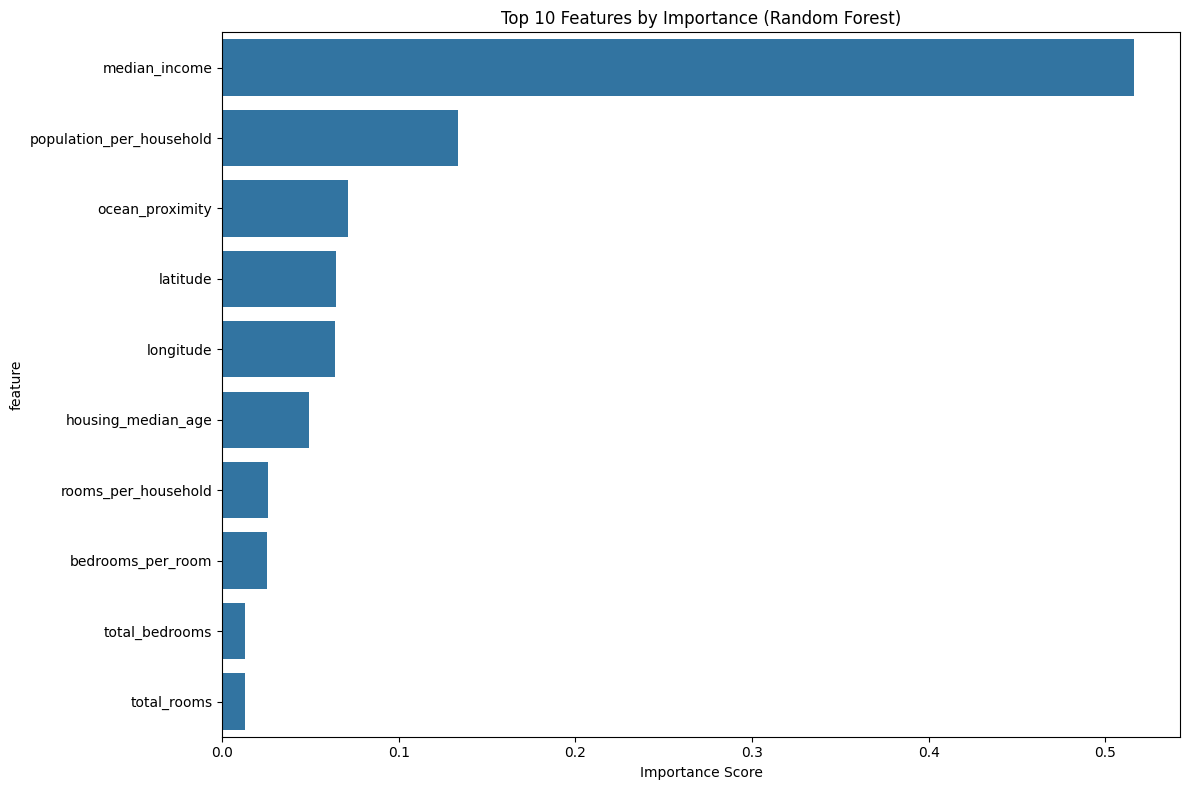

In [12]:
# Feature Importance Analysis
print("Feature Importance Analysis")
print("=" * 50)

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features by Importance:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title("Top 10 Features by Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [13]:
# Save the best model
print("Saving the best model...")

import joblib

# Save Random Forest model
joblib.dump(best_model, '../models/trained_models/housing_model.pkl')
joblib.dump(label_encoders, '../models/trained_models/label_encoders.pkl')

print("Model saved successfully.")
print("Files saved:")
print("- housing_model.pkl")
print("- label_encoders.pkl")

Saving the best model...
Model saved successfully.
Files saved:
- housing_model.pkl
- label_encoders.pkl


In [19]:
# Model Performance Summary
print("Model Development Summary")
print("=" * 60)

print(f"Dataset: {df.shape[0]} samples, {X.shape[1]} features")
print(f"Target: median_house_value (${y.min():,.0f} - ${y.max():,.0f})")

print(f"\nBest Model: Random Forest")
print(f"Test R^2: {results['Random Forest']['test_r2']:.4f}")
print(f"Test RMSE: ${results['Random Forest']['test_rmse']:,.0f}")
print(f"Test MAE: ${results['Random Forest']['test_mae']:,.0f}")

print(f"\nTop 5 Important Features:")
for i, (feature, importance) in enumerate(feature_importance.head(5).values):
    print(f" {i+1}. {feature}: {importance:.4f}")

print(f"\nModel Notes:")
print(f"- Overfitting detected (Train R^2: 0.97, Test R^2: 0.81)")
print(f"- Ready for production with caution")
print(f"- Consider hyperparameter tuning for better generalization")

print(f"\nModel development completed.")

Model Development Summary
Dataset: 20640 samples, 13 features
Target: median_house_value ($14,999 - $500,001)

Best Model: Random Forest
Test R^2: 0.8050
Test RMSE: $50,544
Test MAE: $32,718

Top 5 Important Features:
 1. median_income: 0.5165
 2. population_per_household: 0.1334
 3. ocean_proximity: 0.0711
 4. latitude: 0.0642
 5. longitude: 0.0639

Model Notes:
- Overfitting detected (Train R^2: 0.97, Test R^2: 0.81)
- Ready for production with caution
- Consider hyperparameter tuning for better generalization

Model development completed.
